Importing The libraries to be used

In [1]:
from glob import glob
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
import pywt
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis as scipy_kurtosis

Path for the directory of edf files

In [2]:
all_files = glob('eeg-during-mental-arithmetic-tasks-1.0.0/*.edf')
print(len(all_files))

72


Path for the CSV file and making its dataframe

In [3]:
csv_file_path = './eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv'
df = pd.read_csv(csv_file_path)
df

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0
5,Subject05,16,F,2010,20.71,1
6,Subject06,18,M,2011,4.35,0
7,Subject07,18,F,2012,13.38,1
8,Subject08,26,M,2011,18.24,1
9,Subject09,16,F,2010,7.00,0


In [4]:
Rest_path = [i for i in all_files if '_1' in i.split('\\')[1]]
Task_path = [i for i in all_files if '_2' in i.split('\\')[1]]
print(len(Rest_path),len(Task_path))

36 36


In [5]:
#Now we make a function to read the files whose paths are stored in
#variables Rest and Task
def read_data(file_path):
    # Read the raw EEG data from file_path
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    
    # Apply bandpass filter to the data
    data.filter(l_freq=0.5, h_freq=45)
    # Notch filter for Removal of Line Voltage
    data.notch_filter(freqs=50)
    
    return data

In [6]:
%%capture
Rest = [read_data(i) for i in Rest_path]
Task = [read_data(i) for i in Task_path]


In [7]:
print(type(Task[0]))

<class 'mne.io.edf.edf.RawEDF'>


In [8]:
print(Rest[0].info)

<Info | 9 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: True
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>


Using matplotlib as 2D backend.


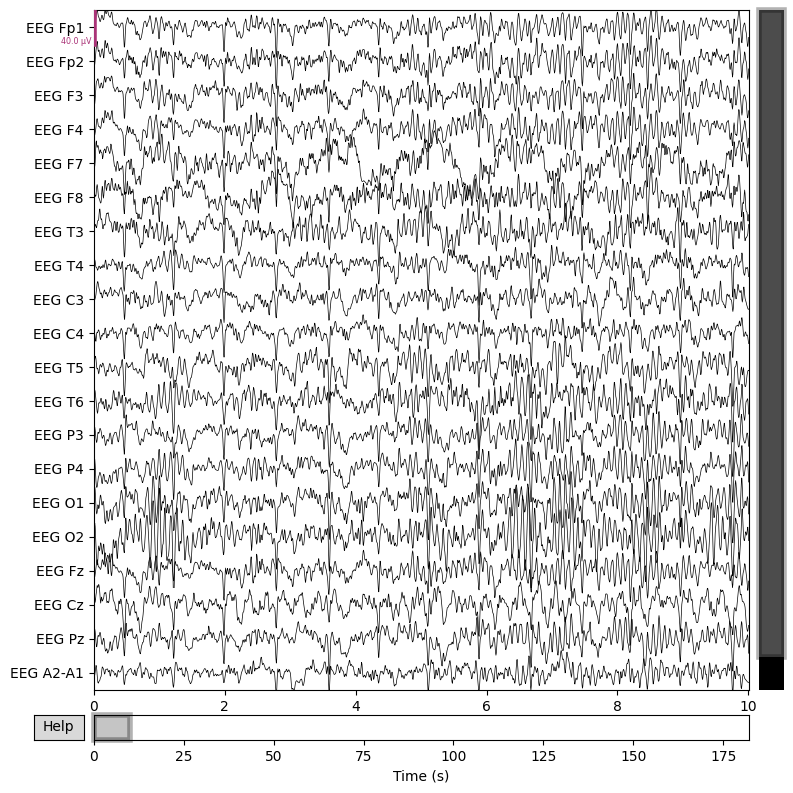

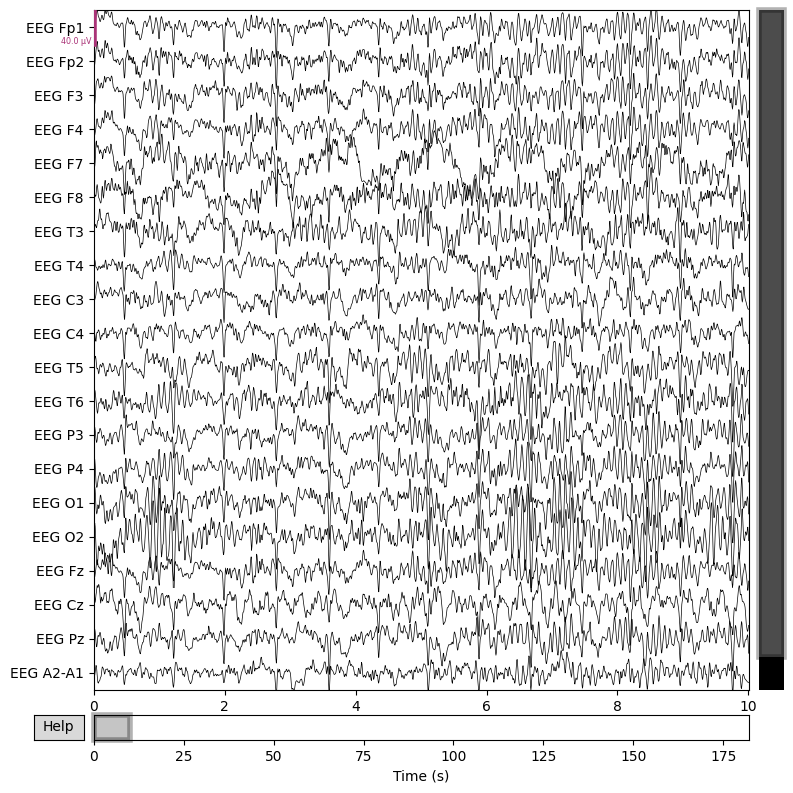

In [9]:
Rest[0].plot()

Calculating the following frequency bands: Delta (1-4
Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100
Hz).

In [10]:
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

In [11]:
def calculate_psd_pair(Rest, Task, fmin=1, fmax=100):
    """
    The function returns a dictionary containing the PSD data for both the rest and task states of the EEG recording, and an array of the corresponding frequencies
    Each band array holds PSD values corresponding to the average power density in that frequency band across the EEG channels:
    Each value in this array represents the mean power density (in units squared per Hz) for the Delta band, averaged across all EEG channels for one recording. The values are very small because power in these bands is distributed across a spectrum, and because of the square of the voltage measurement in power calculations.
    
    Parameters:
    Rest and Task are the edf data.
    """
    
    # Define frequency bands
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 100)
    }

    psd_results = {}

    for label, eeg_data in zip(['Rest', 'Task'], [Rest,Task]):
        # Compute the spectral data using the compute_psd method
        spectrum = eeg_data.compute_psd(method='welch', fmin=fmin, fmax=fmax)
        
        # Extract data and frequencies from the spectrum object
        psd, freqs = spectrum.get_data(return_freqs=True)
        
        # Store PSD for each band
        psd_results[label] = {}
        for band, (fmin_band, fmax_band) in bands.items():
            idx_band = np.logical_and(freqs >= fmin_band, freqs <= fmax_band)
            psd_results[label][band] = psd[:, idx_band].mean(axis=1)
    
    return psd_results


In [12]:
def calculate_psd_pair_mean(Rest,Task, fmin=1, fmax=100):
    
    """
        Calculate the mean Power Spectral Density (PSD) for predefined frequency bands
        from EEG data during 'Rest' and 'Task' states.

        This function processes a pair of EEG recordings for a single subject, one recorded
        during a resting state and the other during a task. It computes the PSD for each state
        using Welch's method across specified frequency bands and returns the mean PSD values
        for each band and state.

        Parameters:
        Rest and Task are the edf data.
        """
    
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 100)
    }

    psd_results = {}

    for label, eeg_data in zip(['Rest', 'Task'], [Rest,Task]):
        # Compute the spectral data using the compute_psd method
        spectrum = eeg_data.compute_psd(method='welch', fmin=fmin, fmax=fmax)
        
        # Extract data and frequencies from the spectrum object
        psd, freqs = spectrum.get_data(return_freqs=True)
        
        # Store PSD for each band
        psd_results[label] = {}
        for band, (fmin_band, fmax_band) in bands.items():
            idx_band = np.logical_and(freqs >= fmin_band, freqs <= fmax_band)
            # Calculate the mean across all electrodes for each frequency band and then take the mean of these values
            psd_results[label][band] = np.mean(psd[:, idx_band], axis=1).mean()

    return psd_results

In [13]:
Task[0].compute_psd(method='welch', fmin=1, fmax=100)

Effective window size : 4.096 (s)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,21
Number of frequency bins,405
Frequency range,1.22 – 99.85 Hz


In [14]:
calculate_psd_pair(Rest[0],Task[0])

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


{'Rest': {'Delta': array([5.75463358e-12, 6.89444410e-12, 8.99585982e-12, 6.91960586e-12,
         1.52289785e-11, 9.99405276e-12, 1.30834211e-11, 8.49455517e-12,
         8.02405918e-12, 6.55649438e-12, 1.81953225e-11, 9.57179174e-12,
         7.97004583e-12, 8.65525468e-12, 9.54157223e-12, 1.01968175e-11,
         7.34479110e-12, 2.21814565e-11, 9.49402547e-12, 5.52175115e-12,
         1.92722479e-09]),
  'Theta': array([2.28921673e-12, 2.68893952e-12, 2.79434131e-12, 2.77758023e-12,
         3.66098207e-12, 3.37769620e-12, 3.82462202e-12, 2.66304623e-12,
         2.97791510e-12, 2.82592891e-12, 4.53190092e-12, 3.28098783e-12,
         2.79927822e-12, 3.02011814e-12, 4.15304516e-12, 5.11796152e-12,
         2.71568828e-12, 3.45985980e-12, 3.36078468e-12, 2.75108033e-12,
         7.33566813e-10]),
  'Alpha': array([6.46346439e-12, 7.40652177e-12, 8.77941954e-12, 8.47929628e-12,
         7.28836024e-12, 6.48724866e-12, 8.83281231e-12, 6.00188834e-12,
         6.07745920e-12, 4.76759587

In [15]:
calculate_psd_pair_mean(Rest[0],Task[0])

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


{'Rest': {'Delta': 1.012306534189353e-10,
  'Theta': 3.803037079230228e-11,
  'Alpha': 4.0999185653018434e-11,
  'Beta': 7.930832755018267e-12,
  'Gamma': 4.547318726519267e-14},
 'Task': {'Delta': 5.043337114402707e-11,
  'Theta': 3.326395069872963e-11,
  'Alpha': 4.8306698382538113e-11,
  'Beta': 8.937694344067408e-12,
  'Gamma': 5.755253300514597e-14}}

In [16]:
psd_mean_dict = {} # Will use this to create seperate frames for delta , theta , alpha , beta , gamma
for i in range(0,36):
    psd_mean_dict[f"Subject_{i}"] = calculate_psd_pair_mean(Rest[i],Task[i])

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective wind

In [17]:
psd_mean_dict

{'Subject_0': {'Rest': {'Delta': 1.012306534189353e-10,
   'Theta': 3.803037079230228e-11,
   'Alpha': 4.0999185653018434e-11,
   'Beta': 7.930832755018267e-12,
   'Gamma': 4.547318726519267e-14},
  'Task': {'Delta': 5.043337114402707e-11,
   'Theta': 3.326395069872963e-11,
   'Alpha': 4.8306698382538113e-11,
   'Beta': 8.937694344067408e-12,
   'Gamma': 5.755253300514597e-14}},
 'Subject_1': {'Rest': {'Delta': 4.379153482536329e-11,
   'Theta': 1.843469125115251e-11,
   'Alpha': 1.2575066546625013e-11,
   'Beta': 2.7527698634114057e-12,
   'Gamma': 1.1228117500693459e-13},
  'Task': {'Delta': 5.312876161894038e-11,
   'Theta': 1.24068496981982e-11,
   'Alpha': 8.81946640013806e-12,
   'Beta': 2.5359280402248325e-12,
   'Gamma': 1.6545065541894432e-13}},
 'Subject_2': {'Rest': {'Delta': 9.296562670729971e-12,
   'Theta': 1.8615207781369734e-12,
   'Alpha': 4.349979646793982e-12,
   'Beta': 9.945130580535838e-13,
   'Gamma': 5.880438811193266e-14},
  'Task': {'Delta': 5.752689800614916e

In [18]:
data_list = []
for subject, details in psd_mean_dict.items():
    row = {
        'Subject': subject,
        **{f'Rest_{band}': values for band, values in details['Rest'].items()},
        **{f'Task_{band}': values for band, values in details['Task'].items()}
    }
    data_list.append(row)

# Create DataFrame , one type of data frame (Maybe used in future , just created once)
df_1 = pd.DataFrame(data_list)

In [19]:
df_1

,Subject,Rest_Delta,Rest_Theta,Rest_Alpha,Rest_Beta,Rest_Gamma,Task_Delta,Task_Theta,Task_Alpha,Task_Beta,Task_Gamma
0,Subject_0,1.012307e-10,3.803037e-11,4.099919e-11,7.930833e-12,4.547319e-14,5.043337e-11,3.326395e-11,4.830670e-11,8.937694e-12,5.755253e-14
1,Subject_1,4.379153e-11,1.843469e-11,1.257507e-11,2.752770e-12,1.122812e-13,5.312876e-11,1.240685e-11,8.819466e-12,2.535928e-12,1.654507e-13
2,Subject_2,9.296563e-12,1.861521e-12,4.349980e-12,9.945131e-13,5.880439e-14,5.752690e-11,1.669240e-11,1.125838e-11,7.690644e-12,2.826431e-13
3,Subject_3,2.100216e-11,1.378310e-11,1.681647e-11,2.975461e-12,6.714761e-14,2.053501e-11,1.288735e-11,1.257121e-11,3.136996e-12,8.343947e-14
4,Subject_4,5.559320e-11,1.340121e-11,1.481614e-11,4.600413e-12,1.639386e-13,4.683716e-11,1.380066e-11,1.304741e-11,4.534179e-12,5.672349e-14
5,Subject_5,1.015171e-10,4.198249e-11,3.798877e-11,1.623528e-11,2.061801e-13,1.007878e-10,3.360645e-11,3.762809e-11,1.735383e-11,2.115250e-13
6,Subject_6,5.792401e-11,1.443692e-11,9.751417e-12,4.959867e-12,5.174991e-14,4.559639e-11,1.176805e-11,8.261525e-12,4.046115e-12,5.346738e-14
7,Subject_7,2.232112e-11,7.188964e-12,9.521779e-12,2.693480e-12,1.872767e-13,2.591608e-11,4.917068e-12,9.230220e-12,2.676601e-12,2.126245e-13
8,Subject_8,1.414966e-10,7.293514e-11,5.143625e-11,1.771680e-11,8.411151e-14,9.869178e-11,9.597552e-11,5.344268e-11,2.013793e-11,8.262872e-14
9,Subject_9,9.949512e-11,3.702382e-11,4.000927e-11,2.176680e-11,3.025755e-13,8.647848e-11,3.695376e-11,4.653736e-11,2.331333e-11,3.206241e-13


In [20]:
data_list = [] # Main dataframe that will be used for anaylysis of mean psds over different frequency brands averaged over all 21 channels

columns = pd.MultiIndex.from_product(
    [['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'], ['Rest', 'Task']],
    names=['Band', 'Condition']
)

# Iterate over each subject in the dictionary
for subject, details in psd_mean_dict.items():
    # Extract values for rest and task, format them in order for the DataFrame
    row = []
    for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
        row.extend([details['Rest'].get(band, None), details['Task'].get(band, None)])
    data_list.append(row)

# Create DataFrame with subject names as index
df = pd.DataFrame(data_list, columns=columns, index=[f"Subject_{i}" for i in range(len(psd_mean_dict))])

In [21]:
df

Band               Delta                       Theta                \
Condition           Rest          Task          Rest          Task   
Subject_0   1.012307e-10  5.043337e-11  3.803037e-11  3.326395e-11   
Subject_1   4.379153e-11  5.312876e-11  1.843469e-11  1.240685e-11   
Subject_2   9.296563e-12  5.752690e-11  1.861521e-12  1.669240e-11   
Subject_3   2.100216e-11  2.053501e-11  1.378310e-11  1.288735e-11   
Subject_4   5.559320e-11  4.683716e-11  1.340121e-11  1.380066e-11   
Subject_5   1.015171e-10  1.007878e-10  4.198249e-11  3.360645e-11   
Subject_6   5.792401e-11  4.559639e-11  1.443692e-11  1.176805e-11   
Subject_7   2.232112e-11  2.591608e-11  7.188964e-12  4.917068e-12   
Subject_8   1.414966e-10  9.869178e-11  7.293514e-11  9.597552e-11   
Subject_9   9.949512e-11  8.647848e-11  3.702382e-11  3.695376e-11   
Subject_10  5.966628e-11  6.468276e-11  3.468077e-11  3.666077e-11   
Subject_11  5.921325e-10  2.145176e-11  5.654544e-11  3.887334e-11   
Subject_12  1.170449e-10  1.084869e-10  4.129632e-11  3.716869e-11   
Subject_13  5.178279e-12  2.982662e-11  1.670930e-12  1.974533e-11   
Subject_14  7.976636e-11  6.059878e-11  1.878993e-11  1.790846e-11   
Subject_15  8.961645e-11  9.174524e-11  1.769522e-11  1.872875e-11   
Subject_16  2.137298e-11  2.204545e-11  3.394550e-11  2.385813e-11   
Subject_17  3.864007e-11  4.262990e-11  1.638208e-11  2.206444e-11   
Subject_18  8.256677e-11  3.907492e-11  8.760119e-11  7.368793e-11   
Subject_19  5.324327e-11  5.377126e-11  1.705096e-11  2.313826e-11   
Subject_20  5.309810e-11  6.934678e-12  1.295388e-11  3.168557e-12   
Subject_21  8.830756e-11  5.730767e-11  3.997237e-11  2.924040e-11   
Subject_22  6.059693e-11  2.771714e-11  2.886362e-11  2.135645e-11   
Subject_23  1.574210e-11  1.678307e-11  1.653172e-11  1.337665e-11   
Subject_24  7.883921e-11  8.037053e-11  2.178174e-11  2.268578e-11   
Subject_25  6.379663e-11  6.249177e-11  3.349756e-11  2.614535e-11   
Subject_26  6.106520e-11  4.894999e-11  2.050619e-11  2.159591e-11   
Subject_27  6.348016e-11  7.560166e-11  5.029853e-11  5.887455e-11   
Subject_28  3.336966e-11  2.949484e-11  8.381818e-12  7.635199e-12   
Subject_29  9.660634e-11  8.020445e-11  2.563248e-11  2.851555e-11   
Subject_30  2.389682e-11  2.345521e-11  2.799175e-11  3.180626e-11   
Subject_31  7.322641e-11  7.495937e-11  2.202785e-11  2.066089e-11   
Subject_32  6.013341e-11  4.242279e-11  2.498142e-11  3.021245e-11   
Subject_33  1.670026e-11  1.503560e-11  3.184782e-12  1.925132e-12   
Subject_34  6.022120e-11  4.185005e-11  1.872685e-11  2.250958e-11   
Subject_35  7.670410e-11  6.351749e-12  1.706519e-11  2.596102e-12   

Band               Alpha                        Beta                \
Condition           Rest          Task          Rest          Task   
Subject_0   4.099919e-11  4.830670e-11  7.930833e-12  8.937694e-12   
Subject_1   1.257507e-11  8.819466e-12  2.752770e-12  2.535928e-12   
Subject_2   4.349980e-12  1.125838e-11  9.945131e-13  7.690644e-12   
Subject_3   1.681647e-11  1.257121e-11  2.975461e-12  3.136996e-12   
Subject_4   1.481614e-11  1.304741e-11  4.600413e-12  4.534179e-12   
Subject_5   3.798877e-11  3.762809e-11  1.623528e-11  1.735383e-11   
Subject_6   9.751417e-12  8.261525e-12  4.959867e-12  4.046115e-12   
Subject_7   9.521779e-12  9.230220e-12  2.693480e-12  2.676601e-12   
Subject_8   5.143625e-11  5.344268e-11  1.771680e-11  2.013793e-11   
Subject_9   4.000927e-11  4.653736e-11  2.176680e-11  2.331333e-11   
Subject_10  1.956664e-11  2.330907e-11  1.022902e-11  1.152628e-11   
Subject_11  2.357266e-11  2.324000e-11  1.329696e-11  1.384585e-11   
Subject_12  2.014116e-11  2.700150e-11  9.241343e-12  9.357223e-12   
Subject_13  9.308531e-13  1.328547e-11  2.573171e-13  4.492924e-12   
Subject_14  1.293847e-11  1.518116e-11  6.364532e-12  9.105583e-12   
Subject_15  2.961110e-11  2.150809e-11  8.076346e-12  8.469131e-12   
Subject_16  1.988866e-11  2.175291e-11  3.320084e-12  3.636489e-12   
Subject_1

In [22]:
# Creating all kinds of dataframes for all freqeuncy bands seprately for plotting them individudally , they contain values for rest and task state of subjects averaged over 21 channels
df_delta = df['Delta']
df_theta = df['Theta']
df_alpha = df['Alpha']
df_beta = df['Beta']
df_gamma = df['Gamma']

# Visualization of all subjects across all 5 frequency bands at rest and task state

In [23]:
def plot_band_psd(df_band, band_name):
    """
    Plots the PSD values for 'Rest' and 'Task' from a given DataFrame for a specific band.

    Parameters:
    - df_band: DataFrame containing 'Rest' and 'Task' PSD values.
    - band_name: String representing the name of the band (e.g., 'Delta', 'Theta').
    """
    # Assuming df_delta is already defined and available
    data_frame = df_band  # This is your DataFrame for the Delta band
    band_name = band_name  # Specifying the band name you want to plot

    # Create a single plot for the Delta band
    fig, ax = plt.subplots(figsize=(10, 4))  # Adjusting the size for a single subplot
    colors = {'Rest': 'skyblue', 'Task': 'salmon'}

    # Plotting Rest and Task data
    data_frame['Rest'].plot(kind='bar', color=colors['Rest'], ax=ax, position=0, width=0.4, label='Rest')
    data_frame['Task'].plot(kind='bar', color=colors['Task'], ax=ax, position=1, width=0.4, label='Task')

    ax.set_title(f'{band_name} Band Power Spectral Density')
    ax.set_xlabel('Subjects')
    ax.set_ylabel('PSD Values')
    ax.legend()

    plt.tight_layout()
    plt.show()


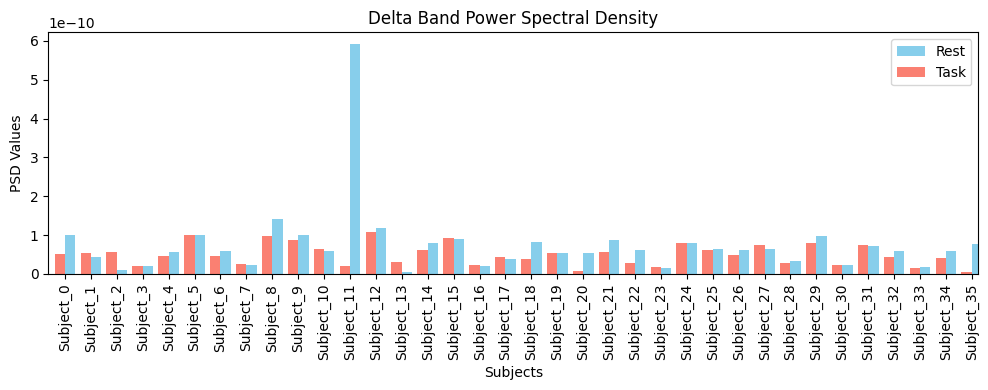

In [24]:
plot_band_psd(df_delta,'Delta') # Delta Plot

### Summary of delta band 

Variability Across Subjects: There seems to be variability in the PSD values across subjects, suggesting individual differences in brain activity in the Delta band. This variability might be linked to different levels of neural synchrony or individual neurophysiological characteristics.

Rest vs. Task Comparison:

Higher PSD During Rest: If, generally, the PSD values are higher during rest compared to task conditions for most subjects, this would align with existing neuroscience research that associates Delta waves with non-REM sleep and deep relaxation states.
Task-Induced Decreases: A decrease in Delta activity during task conditions might indicate a shift in brain state from a restful to a more alert one, reflecting engagement and cognitive processing that suppresses slower wave activity.

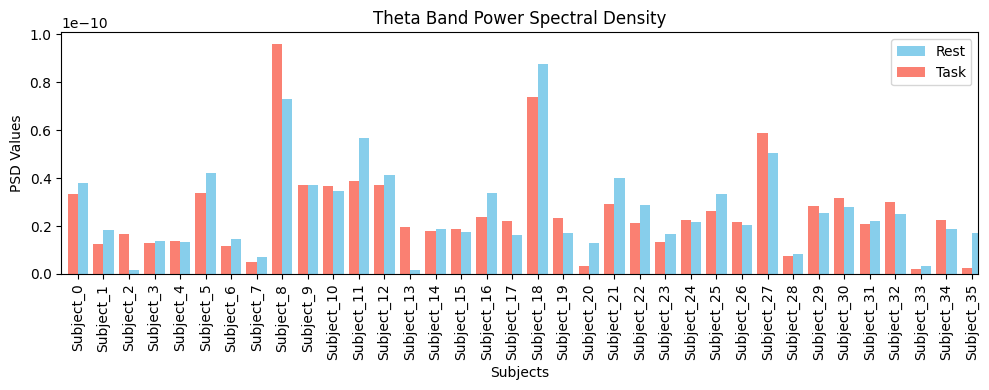

In [25]:
plot_band_psd(df_theta,'Theta') # Theta Plot

### Summary of theta band 

Variability: The data shows significant inter-subject variability, which is typical in EEG studies given the personal differences in brain structure and function.

State Differences: For some subjects, the PSD values in the 'Task' condition are higher compared to the 'Rest' state, which might suggest increased cognitive effort or engagement during the task. Conversely, other subjects show higher values during 'Rest', potentially indicating a more relaxed or meditative state during these periods.

Potential Insights: Higher PSD values in the Theta band during tasks might relate to task-specific demands that engage memory or spatial navigation, which are known to activate Theta rhythms.


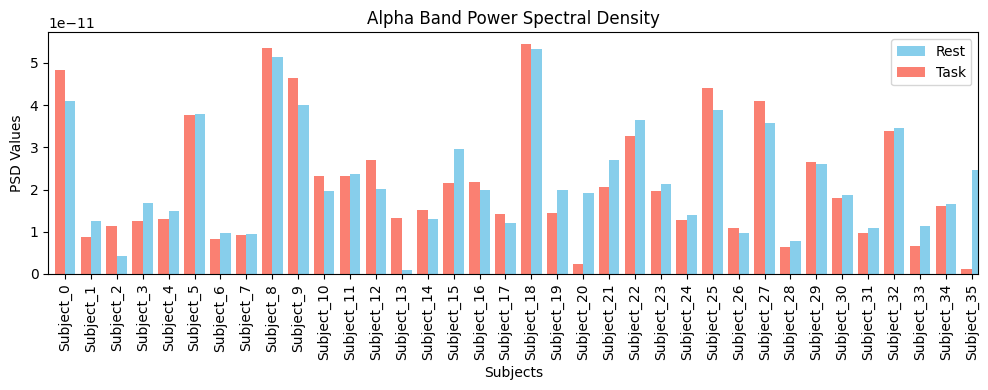

In [26]:
plot_band_psd(df_alpha,'Alpha') # Alpha Plot

### Summary of Alpha band 

Inter-subject Variability: There is noticeable variability in Alpha band power between subjects. This reflects individual differences in baseline brain activities, possibly influenced by physiological, psychological, or methodological factors.

Comparison Between Conditions:

Some subjects exhibit higher Alpha power during the 'Rest' state compared to the 'Task' state. This is expected as Alpha rhythms are typically associated with relaxed, wakeful states with reduced cognitive activity.
Conversely, other subjects show an increase in Alpha power during 'Task'. This could be indicative of tasks that might involve visual imagination, memory recall, or other processes that might increase Alpha activity.
Potential Cognitive Implications:

An increase in Alpha power during tasks might suggest that the task is either under-stimulating, allowing the mind to wander or relax, or that it involves elements (like visualization) that actively engage Alpha rhythms.
A decrease in Alpha power during tasks relative to rest could indicate increased attention and mental focus, suppressing the default Alpha activity.

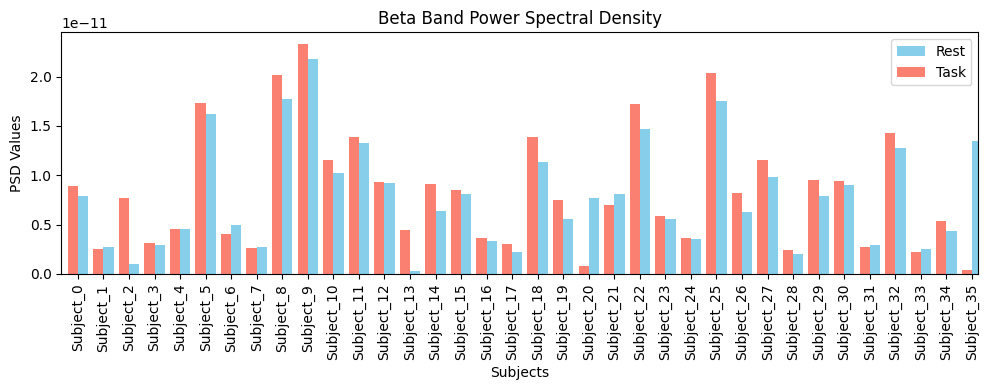

In [27]:
plot_band_psd(df_beta,'Beta') # Beta Plot

### Summary of Beta band 

Inter-subject Variability:

As with the other frequency bands, there's a clear inter-subject variability in the Beta band power. This variability is expected due to individual differences in cognitive processing, neural connectivity, and perhaps even in the specific tasks assigned during the 'Task' state.
Beta Band Dynamics:

Rest State: Beta activity is generally lower during relaxed, non-focused states. The data for some subjects align with this, showing lower Beta power during 'Rest'.
Task State: During tasks that require active engagement, alertness, or concentration (like solving mathematical problems, planning, or decision-making), Beta activity usually increases. The dataset reflects higher Beta power during 'Task' for many subjects, indicating engagement in cognitively demanding activities.
Comparison Between Conditions:

The majority of subjects appear to exhibit higher Beta power during the 'Task' condition compared to 'Rest'. This is typical as Beta waves are linked to active thinking and concentration.
However, there are exceptions where some subjects show minimal change or even decreased Beta activity during 'Task'. This could suggest variations in the nature of the task, individual strategies for task execution, or differing levels of engagement.

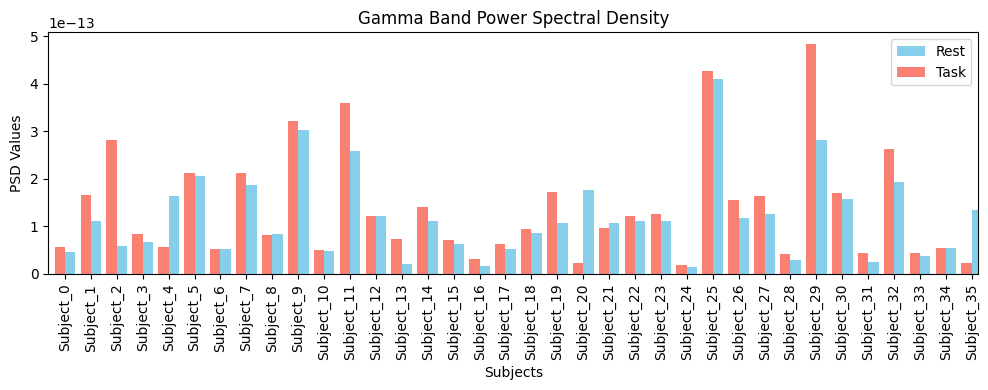

In [28]:
plot_band_psd(df_gamma,'Gamma') # Gamma Plot

### Summary of Gamma band 

Inter-subject Variability:

As with the other frequency bands, there's a clear inter-subject variability in the Gamma band power.
Beta Band Dynamics:

Gamma is mainly associated with task related tasks , so with not with much variablity almost all with some exceptions have task related higher than the rest one.

The majority of subjects appear to exhibit higher Gamma power during the 'Task' condition compared to 'Rest'. This is typical as Gamma waves are linked to active thinking and concentration.
However, there are exceptions where some subjects show minimal change or even decreased Gamma activity during 'Task'. This could suggest variations in the nature of the task, individual strategies for task execution, or differing levels of engagement.

In [29]:
calculate_psd_pair(Rest[0],Task[0])['Rest']['Delta'] # analysing the 21 values across the channels individually for one of the datapoint , in this case of subject 0 at rest state and it's delta frequency band
# Also a method how to fetch all 21 values of 21 channels of any subject , at any state and any frequency band.

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


array([5.75463358e-12, 6.89444410e-12, 8.99585982e-12, 6.91960586e-12,
       1.52289785e-11, 9.99405276e-12, 1.30834211e-11, 8.49455517e-12,
       8.02405918e-12, 6.55649438e-12, 1.81953225e-11, 9.57179174e-12,
       7.97004583e-12, 8.65525468e-12, 9.54157223e-12, 1.01968175e-11,
       7.34479110e-12, 2.21814565e-11, 9.49402547e-12, 5.52175115e-12,
       1.92722479e-09])

In [30]:
len(calculate_psd_pair(Rest[0],Task[0])['Rest']['Delta']) # The length is correct 21 channels 

Effective window size : 4.096 (s)


Effective window size : 4.096 (s)


21

In [31]:
def plot_psd_comparison_single_subject(ax, psd_results):
    """
    Plots a comparison of mean Power Spectral Density (PSD) values across different EEG frequency bands 
    between 'Rest' and 'Task' states for a single subject.

    This function generates a bar chart where each bar represents the mean PSD value for a specific 
    frequency band during 'Rest' and 'Task' conditions. The plot is particularly useful for visualizing 
    differences in brain activity across different conditions and frequency bands.

    Parameters:
    - ax: The axis to plot on.
    - psd_results (dict): A dictionary containing the PSD data structured with top-level keys 'Rest' 
      and 'Task', each mapping to a dictionary of frequency bands ('Delta', 'Theta', 'Alpha', 'Beta', 
      'Gamma') with their corresponding mean PSD values.    
    """
    
    bands = psd_results['Rest'].keys()  # Assuming band keys are the same for Rest and Task
    colors = ['skyblue', 'salmon']  # Colors for Rest and Task bars
    band_labels = list(bands)
    n_bands = len(band_labels)
    
    # Width of a bar
    bar_width = 0.35
    # Setting the positions of the bars
    index = np.arange(n_bands)
    
    # Creating bars for each band
    rest_means = [psd_results['Rest'][band].mean() for band in bands]
    task_means = [psd_results['Task'][band].mean() for band in bands]
    bars1 = ax.bar(index - bar_width/2, rest_means, bar_width, label='Rest', color=colors[0])
    bars2 = ax.bar(index + bar_width/2, task_means, bar_width, label='Task', color=colors[1])

    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Mean PSD (Power/Hz)')
    ax.set_title('Mean PSD Comparison')
    ax.set_xticks(index)
    ax.set_xticklabels(band_labels)
    ax.legend()

    # Log scale for the y-axis
    ax.set_yscale('log')
    # Set a minimum limit to avoid log(0) issue, ensuring all data is visible
    min_val = min(min(rest_means), min(task_means))
    if min_val > 0:
        ax.set_ylim(min_val / 10, max(max(rest_means), max(task_means)) * 10)
    else:
        ax.set_ylim(1e-12, max(max(rest_means), max(task_means)) * 10)

    # Adding value labels on top of each bar
    for bars in (bars1, bars2):
        for bar in bars:
            yval = bar.get_height()
            # Adjust text position for visibility on log scale
            ax.text(bar.get_x() + bar.get_width()/2, yval * 1.1, f'{yval:.2e}', ha='center', va='bottom', fontsize=9, color='black')

In [32]:
n_subjects = len(psd_mean_dict)
n_cols = 2
n_rows = (n_subjects + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 100))

for ax, (subject, psd_results) in zip(axes.flatten(), psd_mean_dict.items()):
    plot_psd_comparison_single_subject(ax, psd_results)
    ax.set_title(f'PSD Comparison - {subject}')

Hjorth Parameters

In [33]:
def compute_hjorth_parameters(eeg_data):
    """
    Compute Hjorth parameters for given EEG data.
    
    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: tuple containing three Hjorth parameters: Activity, Mobility, and Complexity.
    """
    first_derivative = np.diff(eeg_data, axis=1)
    second_derivative = np.diff(first_derivative, axis=1)

    activity = np.var(eeg_data, axis=1)
    mobility_numerator = np.var(first_derivative, axis=1)
    complexity_numerator = np.var(second_derivative, axis=1)

    mobility = np.sqrt(mobility_numerator / activity)
    complexity = np.sqrt(complexity_numerator / mobility_numerator) / mobility

    return activity, mobility, complexity

Kurtosis , 2nd Diff Mean, 2nd Diff Max

In [34]:
def compute_kurtosis(eeg_data):
    """
    Compute Kurtosis, Second Derivative Mean, and Second Derivative Maximum for given EEG data.
    
    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: tuple containing Kurtosis, Second Derivative Mean, and Second Derivative Maximum.
    """
    second_derivative = np.diff(np.diff(eeg_data, axis=1), axis=1)

    kurtosis_values = scipy_kurtosis(eeg_data, axis=1, fisher=False)
    second_diff_mean = np.mean(second_derivative, axis=1)
    second_diff_max = np.max(second_derivative, axis=1)

    return kurtosis_values, second_diff_mean, second_diff_max

Coefficient of Varaition

In [35]:
def compute_coefficient_of_variation(eeg_data):
    """
    Compute the coefficient of variation for given EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: 1D numpy array containing the coefficient of variation for each channel.
    """
    # Compute the mean for each channel
    mean_values = np.mean(eeg_data, axis=1)
    
    # Compute the standard deviation for each channel
    std_values = np.std(eeg_data, axis=1)
    
    # Compute the coefficient of variation for each channel
    coefficient_of_variation = std_values / mean_values

    return coefficient_of_variation

Skewness , 1st Difference Mean, 1st Difference Max

In [36]:
def compute_skewness_and_diff_parameters(eeg_data):
    """
    Compute Skewness, First Difference Mean, and First Difference Maximum for given EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: tuple containing Skewness, First Difference Mean, and First Difference Maximum.
    """
    # Compute the first derivative of the EEG data
    first_derivative = np.diff(eeg_data, axis=1)
    
    # Compute Skewness for each channel
    skewness_values = skew(eeg_data, axis=1)
    
    # Compute the mean of the first derivative for each channel
    first_diff_mean = np.mean(first_derivative, axis=1)
    
    # Compute the maximum of the first derivative for each channel
    first_diff_max = np.max(first_derivative, axis=1)

    return skewness_values, first_diff_mean, first_diff_max

Wavelet transform features

In [37]:
def compute_wavelet_features(eeg_data):
    """
    Compute wavelet features for given EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: tuple containing average wavelet features across all channels.
    """
    cA_values = []
    cD_values = []
    cA_mean = []
    cA_std = []
    cA_Energy = []
    cD_mean = []
    cD_std = []
    cD_Energy = []
    Entropy_D = []
    Entropy_A = []

    for i in range(eeg_data.shape[0]):
        # Calculate the coefficients of wavelet transform
        cA, cD = pywt.dwt(eeg_data[i, :], 'coif1')
        cA_values.append(cA)
        cD_values.append(cD)
    
    for x in range(eeg_data.shape[0]):
        # Calculate mean, standard deviation, energy, and entropy of the coefficients
        cA_mean.append(np.mean(cA_values[x]))
        cA_std.append(np.std(cA_values[x]))
        cA_Energy.append(np.sum(np.square(cA_values[x])))
        cD_mean.append(np.mean(cD_values[x]))
        cD_std.append(np.std(cD_values[x]))
        cD_Energy.append(np.sum(np.square(cD_values[x])))
        Entropy_D.append(np.sum(np.square(cD_values[x]) * np.log(np.square(cD_values[x]))))
        Entropy_A.append(np.sum(np.square(cA_values[x]) * np.log(np.square(cA_values[x]))))

    # Compute average values across all channels
    avg_cA_mean = np.mean(cA_mean)
    avg_cA_std = np.mean(cA_std)
    avg_cD_mean = np.mean(cD_mean)
    avg_cD_std = np.mean(cD_std)
    avg_cA_Energy = np.mean(cA_Energy)
    avg_cD_Energy = np.mean(cD_Energy)
    avg_Entropy_A = np.mean(Entropy_A)
    avg_Entropy_D = np.mean(Entropy_D)

    return avg_cA_mean, avg_cA_std, avg_cD_mean, avg_cD_std, avg_cA_Energy, avg_cD_Energy, avg_Entropy_A, avg_Entropy_D

Variance and Mean of Vertex to Vertex Slope

In [38]:
def first_diff(data):
    """
    Compute the first difference of the input array.

    :param data: 1D numpy array.
    :return: 1D numpy array of first differences.
    """
    out = np.zeros(len(data))
    for j in range(len(data)):
        out[j] = data[j - 1] - data[j]  # Obtaining the 1st Diffs
        j += 1
    return out[1:]

def slope_mean(eeg_data):
    """
    Compute the mean slope of the EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: Mean slope value across all channels.
    """
    output = np.zeros(eeg_data.shape[0])  # Initializing the output array with zeros
    
    for k, channel_data in enumerate(eeg_data):
        amp_max = channel_data[argrelextrema(channel_data, np.greater)[0]]
        t_max = argrelextrema(channel_data, np.greater)[0]
        amp_min = channel_data[argrelextrema(channel_data, np.less)[0]]
        t_min = argrelextrema(channel_data, np.less)[0]
        t = np.concatenate((t_max, t_min), axis=0)
        t.sort()  # sort on the basis of time

        amp = np.zeros(len(t))
        res = np.zeros(len(t) - 1)
        for l in range(len(t)):
            amp[l] = channel_data[t[l]]
        
        amp_diff = first_diff(amp)
        t_diff = first_diff(t)
        
        for q in range(len(amp_diff)):
            res[q] = amp_diff[q] / t_diff[q]
        output[k] = np.mean(res)
    
    return np.mean(output)

def slope_var(eeg_data):
    """
    Compute the variance of the slope of the EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: Variance of the slope value across all channels.
    """
    output = np.zeros(eeg_data.shape[0])  # Initializing the output array with zeros
    
    for k, channel_data in enumerate(eeg_data):
        amp_max = channel_data[argrelextrema(channel_data, np.greater)[0]]
        t_max = argrelextrema(channel_data, np.greater)[0]
        amp_min = channel_data[argrelextrema(channel_data, np.less)[0]]
        t_min = argrelextrema(channel_data, np.less)[0]
        t = np.concatenate((t_max, t_min), axis=0)
        t.sort()  # sort on the basis of time

        amp = np.zeros(len(t))
        res = np.zeros(len(t) - 1)
        for l in range(len(t)):
            amp[l] = channel_data[t[l]]
        
        amp_diff = first_diff(amp)
        t_diff = first_diff(t)
        
        for q in range(len(amp_diff)):
            res[q] = amp_diff[q] / t_diff[q]
        output[k] = np.var(res)
    
    return np.mean(output)

def wrapper3(eeg_data):
    """
    Wrapper function to compute slope mean and slope variance of EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :return: tuple containing slope mean and slope variance.
    """
    var1 = slope_mean(eeg_data)
    var2 = slope_var(eeg_data)
    return var1, var2


FFT features(Max Power)

In [39]:
from scipy import signal

def maxPwelch(eeg_data, Fs):
    """
    Compute the maximum power spectral density (PSD) using Welch's method for given EEG data.

    :param eeg_data: 2D numpy array where rows are channels and columns are data points.
    :param Fs: Sampling frequency.
    :return: tuple containing the maximum PSD values for each frequency band.
    """
    BandF = [0.1, 3, 7, 12, 30]
    PMax = np.zeros((eeg_data.shape[0], len(BandF) - 1))
    
    for j in range(eeg_data.shape[0]):
        # Compute the power spectral density (PSD) using Welch's method
        f, Psd = signal.welch(eeg_data[j, :], Fs)
        
        for i in range(len(BandF) - 1):
            # Find the frequency range for the given band
            fr = np.where((f > BandF[i]) & (f <= BandF[i + 1]))
            # Find the maximum PSD in the frequency range
            PMax[j, i] = np.max(Psd[fr])
    
    # Compute the average maximum PSD for each frequency band across all channels
    avg_PMax = np.mean(PMax, axis=0)
    
    return avg_PMax[0], avg_PMax[1], avg_PMax[2], avg_PMax[3]

Shanon Entropy and Entropy Spectral

In [40]:

def entropy_2d(labels):
    """
    Compute the Shannon entropy for each row of a 2D array of binary vectors.

    :param labels: 2D numpy array where each row contains binary labels (0s and 1s).
    :return: 1D numpy array containing Shannon entropy value for each row.
    """
    entropies = []
    
    for row in labels:
        row = row.astype(int)  # Ensure row is of integer type
        n_labels = len(row)
        counts = np.bincount(row)
        probs = counts[np.nonzero(counts)] / n_labels
        n_classes = len(probs)

        if n_classes <= 1:
            entropies.append(0)
        else:
            entropy_value = - np.sum(probs * np.log(probs)) / np.log(n_classes)
            entropies.append(entropy_value)
    
    return np.array(entropies)

In [41]:
def read_and_process_data(primary_file_path, reference_file_path):
    """
    Read and process EEG data from two EDF files. The primary data is modified 
    with reference to the second file and returns a numpy array suitable 
    for Hjorth parameters computation.

    :param primary_file_path: Path to the primary EDF file.
    :param reference_file_path: Path to the reference EDF file.
    :return: 2D numpy array where rows are channels and columns are data points.
    """
    # Read the primary EEG data from primary_file_path
    primary_data = mne.io.read_raw_edf(primary_file_path, preload=True)
    primary_data.set_eeg_reference()

    # Read the reference EEG data from reference_file_path
    reference_data = mne.io.read_raw_edf(reference_file_path, preload=True)
    reference_data.set_eeg_reference()

    # Apply bandpass filter to the primary data
    primary_data.filter(l_freq=0.5, h_freq=45)

    # Notch filter for removal of line voltage in primary data
    primary_data.notch_filter(freqs=50)

    # Ensure both datasets have the same number of data points
    min_length = min(primary_data.n_times, reference_data.n_times)
    primary_data.crop(tmax=(min_length - 1) / primary_data.info['sfreq'])
    reference_data.crop(tmax=(min_length - 1) / reference_data.info['sfreq'])

    # Subtract the reference data from the primary data
    primary_data._data -= reference_data._data

    # Return the modified primary data as a numpy array
    return primary_data.get_data()

In [42]:
%%capture
pre = [read_and_process_data(i, j) for i, j in zip(Task_path, Rest_path)]

In [43]:
labels_df = pd.read_csv('eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv')
labels = labels_df['Count quality'].values
print(len(labels))

36


In [44]:
group_list=[[i]*len(j) for i,j in enumerate(pre)]
print(group_list)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [14, 

In [45]:
pre_array=np.vstack(pre)
label_array=np.hstack(labels)
group_array=np.hstack(group_list)
print(pre_array.shape,label_array.shape,group_array.shape)

(756, 31000) (36,) (756,)


In [46]:
# hjorth = [compute_hjorth_parameters(i) for i in pre]
# hjorth = np.array(hjorth)
# print(type(hjorth[0][0][0]))
features = []
for i in pre:
    activity, mobility, complexity = compute_hjorth_parameters(i)
    kurtosis_values, second_diff_mean, second_diff_max = compute_kurtosis(i)
    l = [activity, mobility, complexity,kurtosis_values, second_diff_mean, second_diff_max]
    np.concatenate(l,axis=-1)
    features.append(l)

Feature Extraction

In [47]:
feature_array=np.array(features)
print(feature_array.shape)
feature_array=np.moveaxis(feature_array,1,2)
feature_array = np.expand_dims(feature_array, axis=-1)
print(feature_array.shape)

(36, 6, 21)
(36, 21, 6, 1)


In [48]:
pre_array=np.moveaxis(pre_array,0,1)
pre_array.shape

(31000, 756)

In [49]:
# coeff_var = [compute_coefficient_of_variation(i) for i in pre]

In [50]:
# skew = [compute_skewness_and_diff_parameters(i) for i in pre]

In [51]:
# wavelet = [compute_wavelet_features(i) for i in pre]

In [52]:
# wrap = [wrapper3(i) for i in pre]

In [53]:
# FFT = [maxPwelch(i, 500) for i in pre]

In [54]:
# Shanon = [entropy_2d(i) for i in pre]

Model Compiling and fitting

In [55]:
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)


In [56]:
X_train.shape

(28, 21, 6, 1)

In [57]:
y_train = np.vstack(y_train)
print(y_train.shape)
new_column = np.ones((y_train.shape[0], 1)) * -1  # Create a column filled with -1

y_train = np.concatenate((y_train, new_column), axis=1)
print(y_train.shape)

(28, 1)
(28, 2)


In [58]:
y_test = np.vstack(y_test)
print(y_test.shape)
new_column = np.ones((y_test.shape[0], 1)) * -1  # Create a column filled with -1

y_test = np.concatenate((y_test, new_column), axis=1)
print(y_test.shape)

(8, 1)
(8, 2)


In [59]:
from EEGModels import EEGNet


model = EEGNet(nb_classes=2,Chans=21,Samples=6,kernLength=256)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\bhard\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [60]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1071 - loss: 0.7779 - val_accuracy: 0.8750 - val_loss: 0.6825
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3214 - loss: 0.6614 - val_accuracy: 1.0000 - val_loss: 0.6702
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3929 - loss: 0.6125 - val_accuracy: 1.0000 - val_loss: 0.6595
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6071 - loss: 0.6295 - val_accuracy: 1.0000 - val_loss: 0.6496
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8571 - loss: 0.5635 - val_accuracy: 1.0000 - val_loss: 0.6400
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8571 - loss: 0.5805 - val_accuracy: 1.0000 - val_loss: 0.6307
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9643 - loss: 0.5585 - val_accuracy: 1.0000 - val_loss: 0.6213
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9643 - loss: 0.5227 - val_accuracy: 1.0000 - val_loss: 0.6119
E

Performance Evaluation

In [62]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the test set using the trained model
y_pred = model.predict(X_test)

# Apply a threshold to the predictions to convert them to class labels
y_pred_rounded = np.where(y_pred > 0.5, 1, 0)

# Reshape the predictions and true values to be compatible with sklearn metrics
y_pred_reshaped = y_pred_rounded.argmax(axis=1)
y_test_reshaped = y_test.argmax(axis=1)

# Calculate evaluation metrics using the reshaped predictions
accuracy = accuracy_score(y_test_reshaped, y_pred_reshaped)
precision = precision_score(y_test_reshaped, y_pred_reshaped, average='macro')
recall = recall_score(y_test_reshaped, y_pred_reshaped, average='macro')
f1 = f1_score(y_test_reshaped, y_pred_reshaped, average='macro')

# Print the calculated metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
